# predict chart type with a random forest classifier
The Plotly Community Feed has more than a million user-generated charts, many of which include data.  I want to use this data to train a model to predict the kinds of design decisions that a human data analyst would make when looking at a table of data:
- What kind of chart to draw?
    - line
    - bar
    - scatter
    - heatmap
- What goes on the x axis?
- What goes on the y axis? 
- Are any transforms necisary? 

Conveniently, the precident project vizML has packeged up data from the plotly community feed, along with a package of attributes they calculated from cleaned and de-duplicated data.  As a shortcut, I'll start with their processed attributes. Later, we can go back and collect new data from the plotly community feed to add more information about new types of data -- particularly, about chart types good for visualizing genomic data, like a circos plot.  

In [45]:
!pwd

/Users/devon/Documents/GitHub/viz/notebooks


### Dependencies

In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os
from os.path import join
import sys
base_path = os.path.abspath(os.path.join('..'))
if base_path not in sys.path:
    sys.path.append(base_path)


### Load Data

In [50]:
data_dir_name = '../data'
data_file_name = 'features_with_charttype_labels_888k.csv'
df = pd.read_csv(os.path.join(data_dir_name, data_file_name))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888484 entries, 0 to 888483
Columns: 849 entries, Unnamed: 0 to labels
dtypes: bool(120), float64(726), int64(1), object(2)
memory usage: 4.9+ GB


In [51]:
# features data frame without ids or chart type labels
features = df.iloc[:,2:]
features.drop('labels', axis=1, inplace=True)
# one-hot encode labels
labels = pd.get_dummies(df['labels'])
# save a list of column labels for later
chart_names = labels.columns
labels.head()

,bar,box,heatmap,histogram,line,pie,sankey,scatter,table
0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0


In [52]:
# split train and test data
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.2, random_state=42)

### Define and Train Preliminary Model

In [53]:
model = RandomForestClassifier(n_estimators=100, 
                               bootstrap = True,
                               max_features = 'log2')
# Fit on training data
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [54]:
# predictions 
y_pred = model.predict(X_test)
# Probabilities for each class
probs = model.predict_proba(X_test)

In [89]:
# predicitons as a data frame with chart labels
preds = pd.DataFrame(y_pred)
chart_names = labels.columns.tolist()
preds.columns = chart_names

## Model Performance

In [116]:
# Calculate roc auc
auc = roc_auc_score(y_test, preds)
auc

0.876880974139151

In [118]:
print('\nArea Under the Curve: {:.2f}\n'.format(roc_auc_score(y_test, preds)))

print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, preds)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, preds, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, preds, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, preds, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, preds, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, preds, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, preds, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, preds, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, preds, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, preds, average='weighted')))

from sklearn.metrics import classification_report
print('\nClassification Report\n')
print(classification_report(y_test, preds, target_names=chart_names))


Area Under the Curve: 0.88

Accuracy: 0.83

Micro Precision: 0.94
Micro Recall: 0.83
Micro F1-score: 0.88

Macro Precision: 0.96
Macro Recall: 0.76
Macro F1-score: 0.84

Weighted Precision: 0.94
Weighted Recall: 0.83
Weighted F1-score: 0.88

Classification Report

              precision    recall  f1-score   support

         bar       0.93      0.78      0.85     24977
         box       0.98      0.78      0.86      9644
     heatmap       1.00      0.77      0.87      2466
   histogram       0.93      0.82      0.87      5667
        line       0.96      0.85      0.91     72774
         pie       0.98      0.89      0.94      5334
      sankey       1.00      0.74      0.85       198
     scatter       0.91      0.84      0.87     56567
       table       1.00      0.39      0.56        70

   micro avg       0.94      0.83      0.88    177697
   macro avg       0.96      0.76      0.84    177697
weighted avg       0.94      0.83      0.88    177697
 samples avg       0.83      0

/Users/devon/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [101]:
# confusion matrix
confusion = confusion_matrix(
    y_test.idxmax(1), preds.idxmax(1))
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[23631    17     1    27   448    67     0   786     0]
 [ 1792  7478     0   237    16     0     0   121     0]
 [  543     1  1895     3     4     1     0    19     0]
 [  833   106     1  4671     6     1     0    49     0]
 [ 6662    13     2    43 62164     6     0  3884     0]
 [  539     1     0     9     4  4772     0     9     0]
 [   52     0     0     0     0     0   146     0     0]
 [ 7160    45     2    57  1859     3     0 47441     0]
 [   41     0     0     0     0     2     0     0    27]]


Text(0.5, 69.0, 'Predicted label')

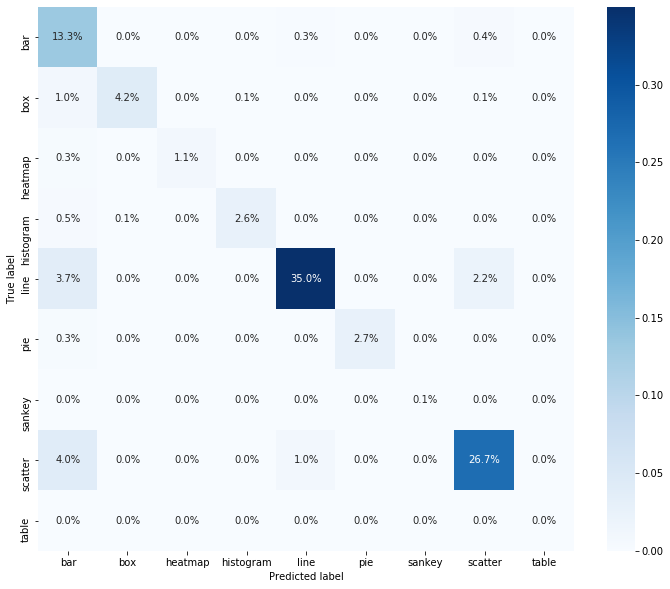

In [124]:
# plot confusion matrix
plt.figure(figsize=(12,10))
sns.heatmap(confusion/np.sum(confusion), annot=True, 
            fmt='.1%', cmap='Blues', xticklabels=chart_names, yticklabels=chart_names)
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Optimize Model Hyperparamiters

In [ ]:
# Create a grid of hyperparamiters to search

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(train_features, train_labels)

### Evaluate Best Model

In [46]:
pd.set_option('display.max_rows', 1000)
features.dtypes
pd.set_option('display.max_rows', 60)

In [32]:
features.dtypes

exists-agg-num                          float64
exists-agg-has                             bool
exists-agg-only_one                        bool
exists-agg-all                             bool
exists-agg-percentage                   float64
                                         ...   
percent_shared_words-agg-avg_abs_dev    float64
percent_shared_words-agg-med_abs_dev    float64
percent_shared_words-agg-min            float64
percent_shared_words-agg-max            float64
labels                                   object
Length: 847, dtype: object

In [37]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 888484 entries, 0 to 888483
Columns: 847 entries, exists-agg-num to labels
dtypes: bool(120), float64(726), object(1)
memory usage: 4.9+ GB


In [39]:
# find columns in df where 
filteredColumns = features.dtypes[features.dtypes == np.object]
# list of columns whose data type is object i.e. string
objcols = list(filteredColumns.index)
print(objcols)

['labels']


In [40]:
features.labels

0         scatter
1         scatter
2             bar
3         scatter
4         scatter
           ...   
888479       line
888480        bar
888481    scatter
888482       line
888483        bar
Name: labels, Length: 888484, dtype: object